# CS2 Dataset Profiling Notebook (Phase2)

This notebook profiles `map_picks_last6m_top50_ml_ready.csv` using expanded checks (missing values, class balance, temporal drift, feature distributions, correlations, and exportable reports).

Run each cell sequentially. The notebook assumes it's placed in the project root `Phase2/` folder and the dataset path is `../map_picks_last6m_top50_ml_ready.csv`.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import os
pd.options.display.max_columns = 200
sns.set(style="whitegrid")

In [7]:
# Load dataset (adjust path if needed)
DATA_PATH = os.path.join('map_picks_last6m_top50_ml_ready.csv')
df = pd.read_csv(DATA_PATH)
print(f'Loaded dataset: {len(df):,} rows, {len(df.columns)} columns')
df.head(3)

Loaded dataset: 2,412 rows, 20 columns


,match_id,date,map,map_number,team_A,team_B,winner,team_A_rank,team_B_rank,rank_diff,abs_rank_diff,picked_by_is_A,is_decider,map_winrate_A,map_winrate_B,recent_form_A,recent_form_B,winner_is_A,split_row,split_match
0,84325,2025-03-25,Mirage,4,B8,Nemiga,B8,23,41,-18,18,1,0,0.5,0.5,0.5,0.5,1,train,train
1,76944,2025-03-25,Train,7,TYLOO,Rare Atom,TYLOO,9,36,-27,27,0,1,0.5,0.5,0.5,0.5,1,train,train
2,84325,2025-03-25,Inferno,7,B8,Nemiga,B8,23,41,-18,18,0,1,0.5,0.5,1.0,0.0,1,train,train


In [8]:
# Basic summary
print('Columns:', df.columns.tolist())
print('Data types:')
print(df.dtypes.value_counts())

# Missing overview
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

Columns: ['match_id', 'date', 'map', 'map_number', 'team_A', 'team_B', 'winner', 'team_A_rank', 'team_B_rank', 'rank_diff', 'abs_rank_diff', 'picked_by_is_A', 'is_decider', 'map_winrate_A', 'map_winrate_B', 'recent_form_A', 'recent_form_B', 'winner_is_A', 'split_row', 'split_match']
Data types:
int64      9
object     7
float64    4
Name: count, dtype: int64


Series([], dtype: int64)

Counts: winner_is_A
1    1310
0    1102
Percentages: winner_is_A
1    54.31%
0    45.69%


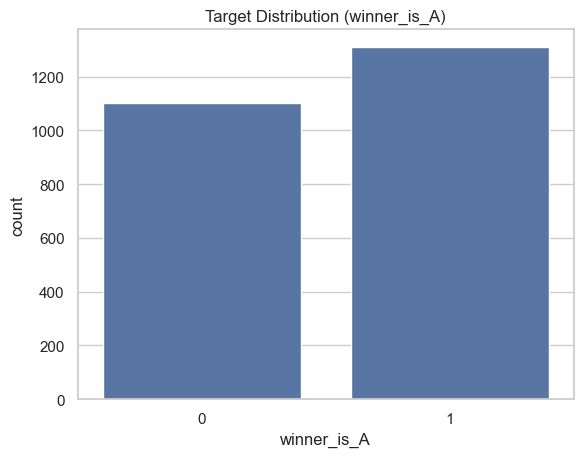

In [9]:
# CLASS BALANCE (Target distribution)
if 'winner_is_A' in df.columns:
    counts = df['winner_is_A'].value_counts()
    pct = df['winner_is_A'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
    print('Counts:', counts.to_string())
    print('Percentages:', pct.to_string())
    sns.countplot(x='winner_is_A', data=df)
    plt.title('Target Distribution (winner_is_A)')
    plt.show()
else:
    print('No winner_is_A column found')

    ym_str   mean_pct  count
0  2025-03  56.756757     37
1  2025-04  56.470588    340
2  2025-05  53.901996    551
3  2025-06  52.218430    293
4  2025-07  58.309859    355
5  2025-08  53.846154    676
6  2025-09  47.500000    160


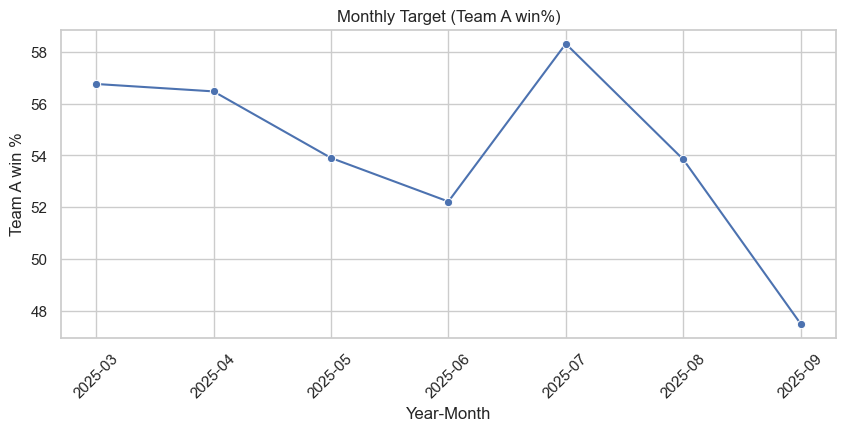

In [10]:
# Temporal drift checks: target rate over time
if 'date' in df.columns and 'winner_is_A' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df['ym'] = df['date'].dt.to_period('M')
    monthly = df.groupby('ym')['winner_is_A'].agg(['mean','count']).reset_index()
    monthly['mean_pct'] = monthly['mean'] * 100
    # Convert Period to string for plotting and export
    monthly['ym_str'] = monthly['ym'].astype(str)
    print(monthly[['ym_str','mean_pct','count']])
    plt.figure(figsize=(10,4))
    sns.lineplot(x='ym_str', y='mean_pct', data=monthly, marker='o')
    plt.title('Monthly Target (Team A win%)')
    plt.xticks(rotation=45)
    plt.xlabel('Year-Month')
    plt.ylabel('Team A win %')
    plt.show()
else:
    print('Missing date or target column for temporal checks')

Numerical columns: ['match_id', 'map_number', 'team_A_rank', 'team_B_rank', 'rank_diff', 'abs_rank_diff', 'picked_by_is_A', 'is_decider', 'map_winrate_A', 'map_winrate_B', 'recent_form_A', 'recent_form_B', 'winner_is_A']


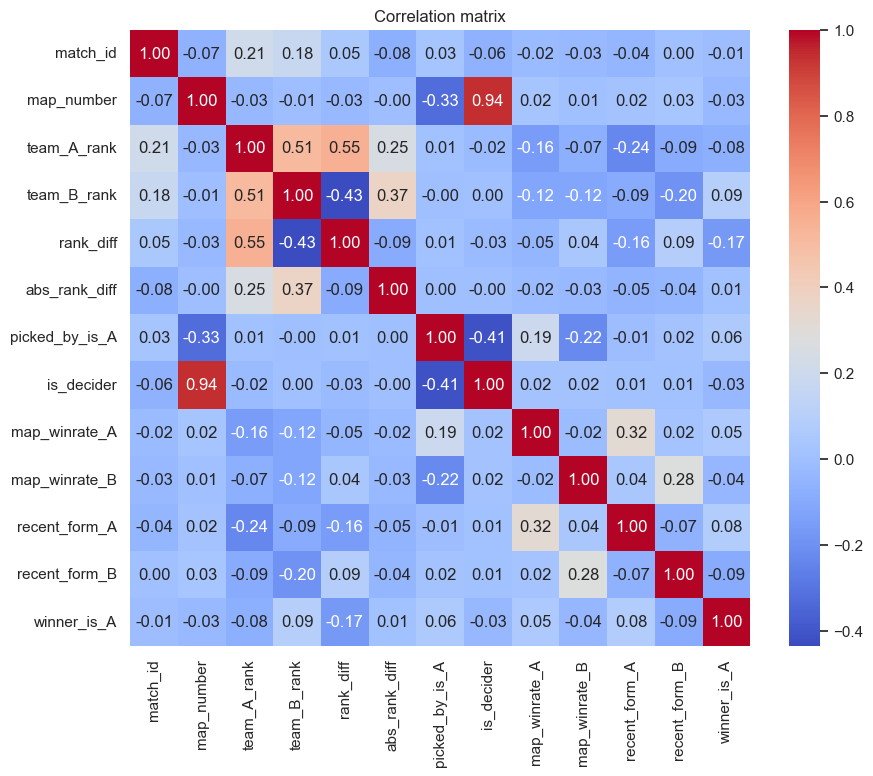

In [11]:
# Correlation heatmap for numerical features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numerical columns:', num_cols)
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

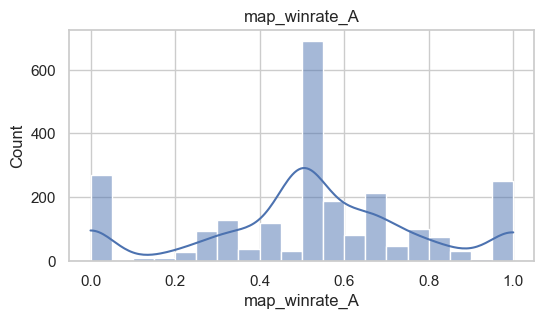

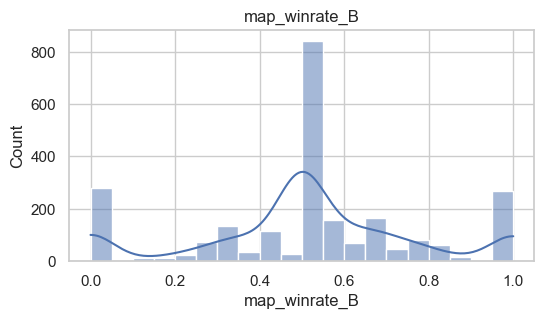

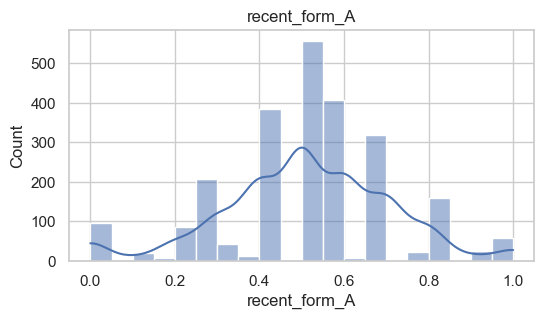

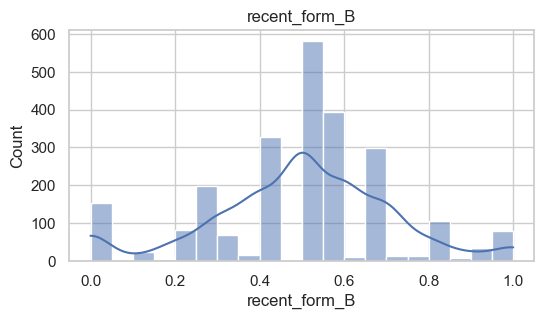

In [12]:
# Feature distributions: map winrates and recent form
for col in ['map_winrate_A','map_winrate_B','recent_form_A','recent_form_B']:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        sns.histplot(df[col].dropna(), kde=True, bins=20)
        plt.title(col)
        plt.show()
    else:
        print(f'{col} not found')

In [13]:
# Export a simple JSON report with missing, class balance and monthly target
report = {}
report['rows'] = len(df)
report['columns'] = len(df.columns)
report['missing_by_column'] = df.isnull().sum().to_dict()
if 'winner_is_A' in df.columns:
    report['class_balance'] = df['winner_is_A'].value_counts().to_dict()
# Export monthly target using ym_str if available
if 'monthly' in globals() and 'ym_str' in monthly.columns:
    report['monthly_target'] = monthly.set_index('ym_str')['mean_pct'].to_dict()
elif 'date' in df.columns and 'winner_is_A' in df.columns:
    # Recompute monthly if not present
    df['date'] = pd.to_datetime(df['date'])
    tmp = df.groupby(df['date'].dt.to_period('M'))['winner_is_A'].mean().mul(100)
    report['monthly_target'] = {str(k): float(v) for k,v in tmp.items()}
with open('phase2_profile_report.json', 'w') as f:
    json.dump(report, f, indent=2)
print('Report written to phase2_profile_report.json')

Report written to phase2_profile_report.json
